# Train feedforward net

In [1]:
import src.midi_utils as midi_utils

import pygame

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
midi_filename = 'midi_data/bwv104.6.mid'
#midi_filename = 'midi_data/pkgsc_azalea.mid'
pygame.init()
pygame.mixer.music.load(midi_filename)
pygame.mixer.music.play()

In [3]:
pygame.mixer.music.stop()

# Neural network

In [43]:
from src.dataset_utils import TrackDataset, get_dataset_representation_from_tracks
from torch.utils.data import DataLoader

soprano_tracks = []
# iterate over all midi files of folder
import glob, os

#os.chdir("./midi_data/bach")
for midi_file in glob.glob("*.mid"):
    # get a list of all soprano tracks
    ## load midi file
    csv_text = midi_utils.load_to_csv(midi_file)

    ## Split into tracks
    track_dict = midi_utils.split_tracks(csv_text)
    track_nr = '1'

    ## Generating numpy array with notes
    track = midi_utils.midi_track_to_numpy(track_dict[track_nr])
    soprano_tracks.append(track)
    
print(len(soprano_tracks))

x, y = get_dataset_representation_from_tracks(soprano_tracks)

print(len(x))

mini_batch_size = 32

train_dataset = TrackDataset(x, y)  # make training dataset
#validation_dataset = TrackDataset(val_images, val_centers)  # make validation dataset
#test_dataset = TrackDataset(test_images, test_centers)  # make test dataset

train_loader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True)
validation_loader = DataLoader(train_dataset, batch_size=mini_batch_size, shuffle=True) # TODO TODO TODO: CHANGE TO A SUITABLE VALIDATIONSET
#test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

357
17204


In [48]:
import torch
import torch.nn as nn
import numpy as np

print("Training set size", len(train_dataset))

input_size = len(train_dataset[0][0])  # get input size
input_example = train_dataset[0][0]
output_size = len(train_dataset[0][1])  # get output size
output_example = train_dataset[0][1]
learning_rate = 0.0001

print("Input size {}/ output size {}/ learning rate {}".format(input_size, output_size, learning_rate))
print("Input example {}".format(input_example))
print("Output example {}".format(output_example))


class LinearModel(nn.Module):

    def __init__(self, input_dimension, output_dimension):
        super(LinearModel, self).__init__()
        self.fc = torch.nn.Linear(input_dimension, output_dimension, bias=True)  # linear layer with parameters A, b

    def forward(self, input_data):
        output = self.fc(input_data)  # applies out = input * A + b. A, b are parameters of nn.Linear that we want to learn
        return output
    
class MLPModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, input):
        return self.layers(input)
    
device=torch.device('cpu')
    
linear_model = LinearModel(input_size, output_size)

linear_model = mlp_model.to(device)

mlp_model = MLPModel(input_size, 64, output_size)

mlp_model = mlp_model.to(device)


criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(mlp_model.parameters(), lr=learning_rate)


def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function, device=torch.device('cpu'), verbose=1):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        # training phase
        model.train()
        # Iterate mini batches over training dataset
        losses = []
        for x, y in train_dataloader:
            x = x.to(device)
            y = y.to(device)
            output = model(x)  # predict output from input
            
            # set gradients to zero
            optimizer.zero_grad()

            loss = loss_function(output, y)
            if verbose > 2:
                print(loss.item())
            loss.backward()
            optimizer.step()

            # Metrics
            losses.append(loss.item())
            
        train_losses.append(np.mean(np.array(losses)))

        # Evaluation phase
        model.eval()
        # iterate mini batches over validation set
        # We don't need gradients
        losses = []
        with torch.no_grad():
            for x, y in val_dataloader:
                x = x.to(device)
                y = y.to(device)
                output = model(x)
                loss = loss_function(output, y)
                if verbose > 1:
                    print(loss.item())

                losses.append(loss.item())
        val_losses.append(np.mean(np.array(losses)))
        
        if verbose > 0:
            print('Epoch {}/{}: train_loss: {:.4f}, val_loss: {:.4f}'.format(epoch + 1, n_epochs, train_losses[-1], val_losses[-1]))
    return train_losses, val_losses


Training set size 17204
Input size 10/ output size 1/ learning rate 0.0001
Input example tensor([74., 77., 74., 74., 74., 74., 75., 74., 72., 72.])
Output example tensor([70.])


In [50]:
# Train the linear model and plot how the loss changes as the 
# training progresses for both training and validation set.
import matplotlib.pyplot as plt
%matplotlib inline

train_losses, val_losses = train(mlp_model, train_loader, validation_loader, optimizer, 100, criterion, verbose=1)

Epoch 1/100: train_loss: 435.1733, val_loss: 391.2992
Epoch 2/100: train_loss: 353.3543, val_loss: 317.9706
Epoch 3/100: train_loss: 287.4284, val_loss: 258.8635
Epoch 4/100: train_loss: 234.1787, val_loss: 211.1693
Epoch 5/100: train_loss: 191.3070, val_loss: 172.7685
Epoch 6/100: train_loss: 156.7170, val_loss: 141.7183
Epoch 7/100: train_loss: 128.8058, val_loss: 116.7646
Epoch 8/100: train_loss: 106.3203, val_loss: 96.5910
Epoch 9/100: train_loss: 88.2039, val_loss: 80.3473
Epoch 10/100: train_loss: 73.5825, val_loss: 67.2614
Epoch 11/100: train_loss: 61.7957, val_loss: 56.6769
Epoch 12/100: train_loss: 52.2798, val_loss: 48.1663
Epoch 13/100: train_loss: 44.6057, val_loss: 41.2959
Epoch 14/100: train_loss: 38.4302, val_loss: 35.7494
Epoch 15/100: train_loss: 33.4383, val_loss: 31.2943
Epoch 16/100: train_loss: 29.4284, val_loss: 27.6800
Epoch 17/100: train_loss: 26.1830, val_loss: 24.7800
Epoch 18/100: train_loss: 23.5666, val_loss: 22.4401
Epoch 19/100: train_loss: 21.4653, val_l

KeyboardInterrupt: 

tensor([[70., 69., 67., 65., 69., 67., 65., 72., 72., 71.],
        [71., 71., 76., 75., 76., 78., 76., 74., 73., 71.],
        [72., 74., 74., 75., 72., 74., 70., 72., 74., 75.],
        [78., 78., 76., 74., 73., 71., 73., 69., 73., 74.],
        [74., 72., 70., 74., 75., 77., 74., 75., 74., 74.],
        [71., 72., 74., 72., 72., 71., 72., 74., 69., 71.],
        [73., 71., 74., 73., 71., 76., 74., 73., 71., 69.],
        [71., 69., 73., 74., 76., 76., 74., 73., 74., 76.],
        [74., 75., 74., 72., 70., 74., 77., 75., 74., 67.],
        [67., 69., 71., 71., 76., 75., 76., 78., 74., 73.],
        [76., 69., 68., 66., 64., 66., 68., 69., 71., 73.],
        [67., 71., 73., 74., 71., 76., 74., 73., 73., 71.],
        [70., 69., 69., 69., 69., 69., 70., 70., 70., 69.],
        [69., 69., 69., 71., 71., 69., 67., 66., 69., 69.],
        [68., 69., 71., 69., 74., 74., 73., 74., 74., 73.],
        [72., 70., 69., 67., 72., 74., 74., 69., 70., 72.],
        [76., 74., 74., 73., 74., 74., 7

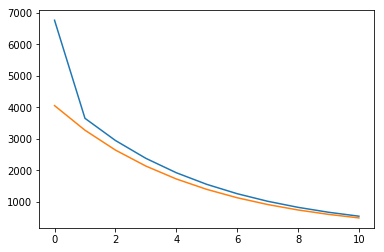

In [51]:
for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    output = mlp_model(x)  # predict output from input

    print(x)
    print("\n")
    print(y)
    print(torch.mean(y).item())
    print("\n")
    print(output)
    break


plt.axis('on')
x = range(len(train_losses))
plt.plot(x, train_losses, x, val_losses)

plt.show()

In [7]:
# write numpy to midi track
new_track = midi_utils.numpy_to_midi_track(numpy_notes, 1, 'Modified')

track_dict['1'] = new_track
modified_midi_filename = 'midi_data/test_modified_track.mid'
modified_csv_list = midi_utils.track_dict_to_csv(track_dict)
midi_utils.write_to_midi(modified_csv_list, modified_midi_filename)

NameError: name 'numpy_notes' is not defined